In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import warnings

import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from conformal.dataframes import load_df, set_test_metrics_columns, op_without_index
from conformal.plot import set_notebook_options, plot_coverage, plot_metrics_on_real_world_datasets_with_separate_axes, savefig, plot_metrics_for_varying_trainingsize
from conformal.visu import map_model, map_dataset

set_notebook_options()
warnings.filterwarnings('ignore', 'All-NaN axis encountered')

#exp_name = 'full2/poisson_gru_mlp-cm_temporal_with_labels'
#path = Path('figures') / exp_name
results_path = Path('results_neurips/full_neurips')
torch.cuda.is_available()

/home/tanguy/miniconda/envs/env_tpp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

## Loading

In [2]:
df_raw = load_df(results_path)
set_test_metrics_columns(df_raw)

Loading results_neurips/full_neurips/poisson_gru_mlp-cm_temporal_with_labels/stack_overflow_shortcal/0.2/N-QR/cal_size=None/run=1.pkl:   0%|          | 0/777 [00:00<?, ?it/s]   

Loading results_neurips/full_neurips/gru_log-normal-mixture_temporal_with_labels/stack_overflow_filtered/0.2/N-QR/cal_size=None/run=0.pkl: 100%|██████████| 777/777 [00:16<00:00, 47.04it/s]         


## Preprocessing

In [3]:
def op(df):
    df = df.copy()
    df['model'] = df['model'].map(map_model)
    df['dataset'] = df['dataset'].map(map_dataset)
    return df

df = op_without_index(df_raw, op)

In [4]:
def relative_length(x):
    return x / x.min()

df['relative_length'] = df.groupby(list(set(df.index.names) - {'conformalizer', 'run_id'}), dropna=False)['specialized_length'].transform(relative_length)

In [4]:
def median_length(x):
    return np.median(x)

df['median_length'] = df['lengths'].transform(median_length)

## Metrics plots

In [5]:
query_list = ['LastFM-F', 'LastFM-S', 'LastFM-L', 'LastFM-SL']
query_list = ['LastFM-S', 'LastFM-L']
model_list = ['LN']
df_plot = df.query('dataset in @query_list and model in @model_list' )

In [6]:
mpl.rcParams['axes.formatter.limits'] = (-4, 4)

path = Path('figures/neurips') 


for type, plot_df in df_plot.groupby('type', dropna=False):
    plot_df = plot_df.query('cal_size.isna() or cal_size == 1024')
    for model, df_model in plot_df.groupby('model', dropna=False):
        print(model)
        plot_metrics_on_real_world_datasets_with_separate_axes(df_model.query('dataset != "Hawkes"'), alpha=0.2, type=type)
        savefig(path / 'real_world_metrics' / 'per_model_neurips' / f'{model}_{type}.pdf')

LN


## Coverage per level plots

In [12]:
for metric in ['coverage']:
    for type, df_type in df.groupby('type', dropna=False):
        df_type = df_type.query('cal_size.isna() or cal_size == 1024')
        for model, df_model in df_type.groupby('model', dropna=False):
            plot_coverage(df_model, metric, ncols=6, type=type)
            savefig(path / f'{metric}_per_level' / model / f'{type}.pdf')

/ssd/bdml1/tanguy/cntpp_neurips/conformal/dataframes.py:136: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(df.index.names, dropna=False).agg(agg_fn)
/ssd/bdml1/tanguy/cntpp_neurips/conformal/dataframes.py:136: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(df.index.names, dropna=False).agg(agg_fn)
/ssd/bdml1/tanguy/cntpp_neurips/conformal/dataframes.py:136: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid 

## Others

In [ ]:
for type, plot_df in df.groupby('type', dropna=False):
    for model, df_model in plot_df.groupby('model', dropna=False):
        plot_metrics_for_varying_trainingsize(df_model, alpha=0.2, type=type)
        savefig(path / 'trainingsize' / f'train_{model}_{type}.pdf')

## Distribution of region size ##

C-Const
C-HDR-T
Warning, region of size 20.148609518753652 predicted
C-QR
C-QRL


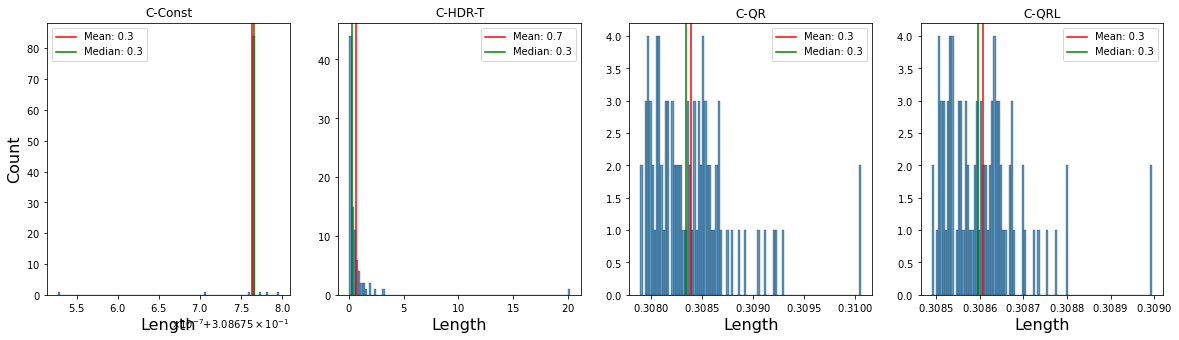

In [12]:
from conformal.plot import region_length_distributions

dataset = 'lastfm_superlargecal'
model = 'gru_log-normal-mixture_temporal_with_labels'
split = 1

region_length_distributions(df_raw, model, dataset, split)

## Mark Calibration

In [ ]:
from plot.plots_esann import mark_calibration

results_dir = 'results/full'
save_dir = 'figures/calibration/mark'

models = [
    'gru_cond-log-normal-mixture_temporal_with_labels',
    'poisson_gru_mlp-cm_temporal_with_labels',
    'identity_poisson_times_only'
]

datasets  = [
    'lastfm',
    'mooc',
    'reddit',
    'stack_overflow'
]


for dataset in datasets:
    mark_calibration(models, dataset, results_dir, splits=3, save_dir=save_dir, title=None)

## Time Calibration ##

In [2]:
from plot.plots_esann import time_calibration

results_dir = 'results/full'
save_dir = 'figures/calibration/time'

models = [
    'gru_cond-log-normal-mixture_temporal_with_labels',
    'poisson_gru_mlp-cm_temporal_with_labels',
    'identity_poisson_times_only'
]

datasets  = [
    'lastfm',
    'mooc',
    'reddit',
    'stack_overflow'
]


for dataset in datasets:
    time_calibration(models, dataset, results_dir, splits=1, save_dir=save_dir, title=None)

## Debug Section

In [17]:
from conformal.dataframes import CPU_Unpickler

'''
for i in range(3):
    path = f'results_neurips/full/gru_cond-log-normal-mixture_temporal_with_labels/lastfm/0.2/C-HDR-T/cal_size=None/run={i}.pkl'
    with open(path, 'rb') as f:
        df = CPU_Unpickler(f).load()
    print(df['metrics'].item()['specialized_length'])
'''

#path1 = 'results_neurips/full2/gru_cond-log-normal-mixture_temporal_with_labels/lastfm/0.2/C-HDR-T/cal_size=None/run=0.pkl'

path = 'results_neurips/full3/gru_log-normal-mixture_temporal_with_labels/lastfm_window/0.2/C-HDR-T/cal_size=None/run=1.pkl'
#paths = [path1, path2]

#path = f'results_neurips/full2/gru_cond-log-normal-mixture_temporal_with_labels/lastfm/0.2/C-HDR-T/cal_size=None/run=0.pkl'
with open(path, 'rb') as f:
        df = CPU_Unpickler(f).load()
print(df['metrics'].item()['coverage'])
print(df['metrics'].item()['specialized_length'])
#for k in range(len(df['metrics'].item()['preds'])):
#    print(df['metrics'].item()['preds'][k][0])

0.800000011920929
46.68883514404297


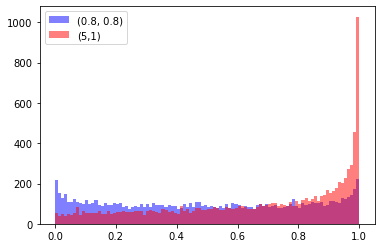

In [42]:
from torch.distributions import Beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

alpha1 = Beta(0.8, 0.8).sample((10000,)).sort().values

ax.hist(alpha1.numpy(), bins=100, color='blue', label='(0.8, 0.8)', alpha=0.5)

alpha2 = Beta(1, 0.5).sample((10000,)).sort().values
ax.hist(alpha2.numpy(), bins=100, color='red', label='(5,1)', alpha=0.5) 

ax.legend()
plt.show()

In [2]:
from conformal.dataframes import CPU_Unpickler
#path_0 = 'results_neurips/full_neurips/gru_log-normal-mixture_temporal_with_labels/lastfm_superlargecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'
#path_1 = 'results_neurips/full_neurips/gru_log-normal-mixture_temporal_with_labels/lastfm_superlargecal/0.2/C-HDR-T/cal_size=None/run=1.pkl'
#path_2 = 'results_neurips/full_neurips/gru_log-normal-mixture_temporal_with_labels/lastfm_superlargecal/0.2/C-HDR-T/cal_size=None/run=2.pkl'

#path_0 = 'results_neurips/full_neurips/poisson_gru_mlp-cm_temporal_with_labels/lastfm_shortcal/0.2/C-HDR-T/cal_size=None/run=0.pkl'
#path_1 = 'results_neurips/full_neurips/poisson_gru_mlp-cm_temporal_with_labels/lastfm_shortcal/0.2/C-HDR-T/cal_size=None/run=1.pkl'
#path_2 = 'results_neurips/full_neurips/poisson_gru_mlp-cm_temporal_with_labels/lastfm_shortcal/0.2/C-HDR-T/cal_size=None/run=2.pkl'

#path_0 = 'results_neurips/full_neurips/identity_poisson_times_only/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'
#path_1 = 'results_neurips/full_neurips/identity_poisson_times_only/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=1.pkl'
#path_2 = 'results_neurips/full_neurips/identity_poisson_times_only/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=2.pkl'

path_0 = 'results_neurips/full_neurips2/gru_log-normal-mixture_temporal_with_labels/lastfm_1000/0.2/C-HDR-T/cal_size=None/run=0.pkl'
path_1 = 'results_neurips/full_neurips2/gru_log-normal-mixture_temporal_with_labels/lastfm_1000/0.2/C-HDR-T/cal_size=None/run=1.pkl'
path_2 = 'results_neurips/full_neurips2/gru_log-normal-mixture_temporal_with_labels/lastfm_1000/0.2/C-HDR-T/cal_size=None/run=2.pkl'

paths = [path_0, path_1, path_2]

for path in paths:
        with open(path, 'rb') as f:
                df = CPU_Unpickler(f).load()
        print('Length', df['metrics'].item()['specialized_length'])     
        print('Coverage', df['metrics'].item()['coverage'])    
        print('q', df['metrics'].item()['q'])
        print('\n')


Length 55.26105499267578
Coverage 0.7888888716697693
q tensor(0.9871, dtype=torch.float64)


Length 92.3140640258789
Coverage 0.800000011920929
q tensor(0.9750, dtype=torch.float64)


Length 42.56452560424805
Coverage 0.8444444537162781
q tensor(0.9717, dtype=torch.float64)




In [ ]:
import matplotlib.pyplot as plt 
from conformal.dataframes import CPU_Unpickler

path_ln_l = 'results_neurips/full3/gru_log-normal-mixture_temporal_with_labels_nomix/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'


path_lnm_l = 'results_neurips/full2/gru_log-normal-mixture_temporal_with_labels/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'
path_cln_l = 'results_neurips/full2/gru_cond-log-normal-mixture_temporal_with_labels_nomix/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'
path_clnm_l = 'results_neurips/full2/gru_cond-log-normal-mixture_temporal_with_labels/lastfm_largecal/0.2/C-HDR-T/cal_size=None/run=0.pkl'

for path in paths_chdrt:
        with open(path, 'rb') as f:
                df = CPU_Unpickler(f).load()
        print('Length', df['metrics'].item()['specialized_length'])     
        print('Coverage', df['metrics'].item()['coverage'])    
        print('q', df['metrics'].item()['q'])
        print('\n')